#Устанавливаем необходимые пакеты

In [1]:
!pip install efficientnet-pytorch
!pip install Wandb
!pip install pytorch_lightning
!pip install python-docx

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=b671737769c48c37f85a4b9de687bb8dac88fc1892eb7693d35894f4eb665f07
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.4 MB/s eta 0:00:00


#Импорты и Настройки

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
import random
import argparse
from argparse import Namespace, ArgumentParser
from typing import List, Optional
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.nn import functional as F
from pytorch_lightning import LightningModule, Trainer, seed_everything
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from torch.optim import Adam
from efficientnet_pytorch import EfficientNet
import wandb
from torch.optim.lr_scheduler import OneCycleLR
from collections import OrderedDict
from docx import Document

#Настройки среды

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
plt.rcParams['figure.max_open_warning'] = 15

#Подготовка данных

In [4]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/car_data'
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomCrop(350),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std, inplace=True)
])

train = ImageFolder(os.path.join(data_dir, 'train'), train_transforms)
batch_size = 10
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=0, pin_memory=True)

val_transforms = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.CenterCrop(350),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val = ImageFolder(os.path.join(data_dir, 'test'), val_transforms)
val_dl = DataLoader(val, batch_size=batch_size, num_workers=0, pin_memory=True)

val_dataset = val
val_dataloader = val_dl

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/car_data/train'

# Визуализация

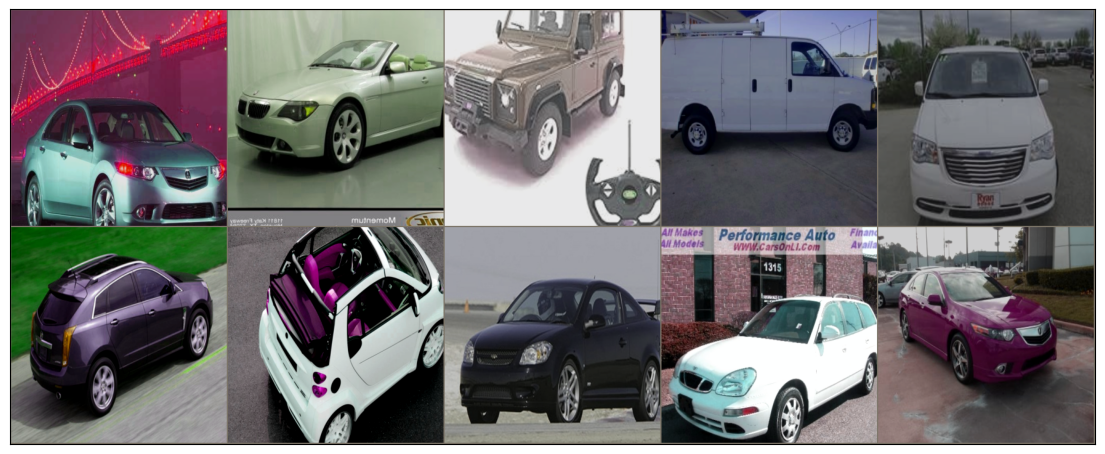

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]); ax.set_yticks([])
        imshow(make_grid(images[:10], nrow=5))
        break
show_batch(train_dl)

#Альбументация

In [ ]:
def pre_transforms():
    return [albu.Resize(400, 400, p=1),
            albu.PadIfNeeded(min_height=400, min_width=400, always_apply=True, border_mode=0)]

def hard_transforms():
    result = [
        albu.RandomCrop(352, 352, always_apply=True),
        albu.HorizontalFlip(p=0.5),
        albu.OneOf([
            albu.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
        ], p=0.9),
        albu.OneOf([
            albu.IAASharpen(p=1),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1),
        ], p=0.9),
        albu.IAAAdditiveGaussianNoise(p=0.2)
    ]
    return result

def post_transforms():
    return [albu.Normalize(), ToTensorV2()]

def compose(transforms_to_compose):
    return albu.Compose([item for sublist in transforms_to_compose for item in sublist])

#Набор Данных

In [ ]:
ROOT = Path("/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/car_data")
train_image_path = ROOT / "train/Audi S6 Sedan 2011/"
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))

def show_examples(name: str, image: np.ndarray, image2: np.ndarray):
    plt.figure(figsize=(12, 16))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.show()

def show(index: int, images: List[Path], transforms=None) -> None:
    image_path = images[index]
    image_path2 = images[index + 4]
    name = image_path.name
    image = np.array(Image.open(image_path))
    image2 = np.array(Image.open(image_path2))
    temp = transforms(image=image)
    temp2 = transforms(image=image2)
    image = temp["image"]
    image2 = temp2['image']
    show_examples(name, image, image2)

def show_random(images: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 5)
    show(index, images, transforms)

class ClassificationDataset(Dataset):
    def __init__(self, images: List[Path], transforms=None) -> None:
        self.images = images
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image_path2 = self.images[idx + 4]
        image = np.array(Image.open(image_path))
        image2 = np.array(Image.open(image_path2))
        result = {"image": image, 'image2': image2}
        result = self.transforms(**result)
        result["filename"] = image_path.name
        return result

show_transforms = compose([pre_transforms(), hard_transforms()])

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


#Определение Модели

In [ ]:
BN_TYPES = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

def _make_trainable(module: nn.Module) -> None:
    for param in module.parameters():
        param.requires_grad = True
    module.train()

def _recursive_freeze(module: nn.Module, train_bn: bool = True) -> None:
    children = list(module.children())
    if not children:
        if not (isinstance(module, BN_TYPES) and train_bn):
            for param in module.parameters():
                param.requires_grad = False
            module.eval()
        else:
            _make_trainable(module)
    else:
        for child in children:
            _recursive_freeze(module=child, train_bn=train_bn)

def freeze(module: nn.Module, n: Optional[int] = None, train_bn: bool = True) -> None:
    children = list(module.children())
    n_max = len(children) if n is None else int(n)
    for child in children[:n_max]:
        _recursive_freeze(module=child, train_bn=train_bn)
    for child in children[n_max:]:
        _make_trainable(module=child)

#Определение Модели ResNet152


In [ ]:
class ResNet152(LightningModule):

    def __init__(self,
                 train_bn: bool = True,
                 batch_size: int = 30,
                 lr: float = 1e-3,
                 num_workers: int = 4,
                 hidden_1: int = 1024,
                 hidden_2: int = 512,
                 epoch_freeze: int = 8,
                 total_steps: int = 15,
                 pct_start: float = 0.2,
                 anneal_strategy: str = 'cos',
                 **kwargs):
        super().__init__()
        self.train_bn = train_bn
        self.batch_size = batch_size
        self.lr = lr
        self.num_workers = num_workers
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.epoch_freeze = epoch_freeze
        self.total_steps = total_steps
        self.pct_start = pct_start
        self.anneal_strategy = anneal_strategy
        self.save_hyperparameters()

        self.__build_model()

    def __build_model(self):
        num_target_classes = 196
        backbone = models.resnet152(pretrained=True)

        _layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*_layers)

        _fc_layers = [nn.Linear(2048, self.hidden_1),
                      nn.Linear(self.hidden_1, self.hidden_2),
                      nn.Linear(self.hidden_2, num_target_classes)]
        self.fc = nn.Sequential(*_fc_layers)

    def forward(self, x):

        x = self.feature_extractor(x)
        x = x.squeeze(-1).squeeze(-1)

        x = self.fc(x)
        return x

    def train(self, mode=True):
        super().train(mode=mode)

        epoch = self.current_epoch
        if epoch < self.epoch_freeze and mode:
            freeze(module=self.feature_extractor,
                   train_bn=self.train_bn)

    def training_step(self, batch, batch_idx):

        x, y = batch
        y_logits = self.forward(x)

        train_loss = F.cross_entropy(y_logits, y)
        acc = accuracy(y_logits, y)

        tqdm_dict = {'train_loss': train_loss}
        output = OrderedDict({'loss': train_loss,
                              'train_acc': acc,
                              'log': tqdm_dict,
                              'progress_bar': tqdm_dict})

        return output

    def training_epoch_end(self, outputs):

        train_loss_mean = torch.stack([output['loss']
                                       for output in outputs]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in outputs]).mean()

        tensorboard_logs = {'train_loss': train_loss_mean, 'train_acc': avg_acc}
        return {'train_loss': train_loss_mean, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):

        x, y = batch
        y_logits = self.forward(x)

        val_loss = F.cross_entropy(y_logits, y)
        acc = accuracy(y_logits, y)

        return {'val_loss': val_loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):

        val_loss_mean = torch.stack([output['val_loss']
                                     for output in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': val_loss_mean, 'val_acc': avg_acc}
        return {'val_loss': val_loss_mean, 'log': tensorboard_logs}

    def configure_optimizers(self):
        if self.current_epoch < self.epoch_freeze:

            optimizer = optimizer.Adam(filter(lambda p: p.requires_grad,
                                          self.parameters()),
                                   lr=self.lr)
            return optimizer

        else:

            optimizer = optimizer.Adam(filter(lambda p: p.requires_grad,
                                          self.parameters()),
                                   lr=self.lr)

            scheduler = OneCycleLR(optimizer,
                                   max_lr=self.lr,
                                   total_steps=self.total_steps,
                                   pct_start=self.pct_start, anneal_strategy=self.anneal_strategy)

        return [optimizer], [scheduler]

    def setup(self, stage: str):
        data_dir = '/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/car_data'

        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        train_transforms = transforms.Compose([
            transforms.Resize((400, 400)),
            transforms.RandomCrop(350),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
        train = ImageFolder(data_dir + '/train', train_transforms)

        val_transforms = transforms.Compose([
            transforms.Resize((400, 400)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
        val = ImageFolder(data_dir + '/test', val_transforms)
        valid, _ = random_split(val, [len(val), 0])

        self.train_dataset = train
        self.val_dataset = valid

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True,
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False,
                          pin_memory=True)



#Определение Модели EffNet

In [ ]:
class EffNet(LightningModule):
    def __init__(self, num_target_classes=246, #если не 196
                 backbone: str = 'efficientnet-b5', batch_size: int = 8,
                 lr: float = 5e-4, wd: float = 0, num_workers: int = 4, factor: float = 0.5, **kwargs):
        super().__init__()
        self.num_target_classes = num_target_classes
        self.backbone = backbone
        self.batch_size = batch_size
        self.lr = lr
        self.wd = wd
        self.num_workers = num_workers
        self.factor = factor
        self.save_hyperparameters()
        self.__build_model()

    def __build_model(self):
        self.net = EfficientNet.from_pretrained(self.backbone)
        in_features = self.net._fc.in_features
        _fc_layers = [nn.Linear(in_features, self.num_target_classes)]
        self.net._fc = nn.Sequential(*_fc_layers)

    def setup(self, stage: str):
        data_dir = '/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/car_data'
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        train_transforms = transforms.Compose([
            transforms.Resize((400, 400)),
            transforms.RandomCrop(350),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
        train = ImageFolder(os.path.join(data_dir, 'train'), train_transforms)

        val_transforms = transforms.Compose([
            transforms.Resize((400, 400)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
        val = ImageFolder(os.path.join(data_dir, 'test'), val_transforms)
        valid, _ = random_split(val, [len(val), 0])

        self.train_dataset = train
        self.val_dataset = valid

    def val_acc(self, y_pred, y_true):
        return accuracy(y_pred, y_true)

    def forward(self, x):
        return self.net.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_logits = self.forward(x)
        train_loss = F.cross_entropy(y_logits, y)
        return train_loss

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers, shuffle=True, pin_memory=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_logits = self.forward(x)
        val_loss = F.cross_entropy(y_logits, y)
        acc = self.val_acc(y_logits, y)
        return {'val_loss': val_loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        val_loss_mean = torch.stack([output['val_loss'] for output in outputs]).mean()
        val_acc_mean = torch.stack([output['val_acc'] for output in outputs]).mean()
        self.log('val_loss', val_loss_mean)
        self.log('val_acc', val_acc_mean)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        lr_scheduler = {'scheduler': ReduceLROnPlateau(optimizer, factor=self.factor, patience=2, mode='max'),
                        'name': 'learning_rate', 'monitor': 'val_acc'}
        return [optimizer], [lr_scheduler]

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers, shuffle=False, pin_memory=True)

#Командный Интерфейс(log обучения прилагаю)

In [ ]:
class EffNetCLI(EffNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--backbone', type=str, default='efficientnet-b7', help='Backbone architecture')
        parser.add_argument('--batch_size', type=int, default=8, help='Batch size')
        parser.add_argument('--lr', type=float, default=5e-4, help='Learning rate')
        parser.add_argument('--wd', type=float, default=0, help='Weight decay')
        parser.add_argument('--num_workers', type=int, default=4, help='Number of workers for data loading')
        parser.add_argument('--factor', type=float, default=0.5, help='Factor for reducing learning rate')
        return parser

    @staticmethod
    def get_args() -> Namespace:
        parent_parser = ArgumentParser(add_help=False)
        parent_parser.add_argument('--gpus', type=int, default=1, help='Number of GPUs')
        parent_parser.add_argument('--use-16bit', dest='use_16bit', action='store_true', help='Use 16-bit precision')
        parent_parser.add_argument('--epochs', default=15, type=int, metavar='N', help='Total number of epochs', dest='nb_epochs')
        parent_parser.add_argument('--patience', default=3, type=int, metavar='ES', help='Early stopping patience', dest='patience')

        parser = EffNetCLI.add_model_specific_args(parent_parser)
        return parser.parse_args()

def main(args):
    seed_everything(42)
    model = EffNetCLI(**vars(args))
    wandb.login(key=os.environ.get('WANDB_API_KEY'))
    wandb_logger = WandbLogger(name='Name', project="Project")
    checkpoint_cb = ModelCheckpoint(dirpath='./', filename='cars-{epoch:02d}-{val_acc:.4f}', monitor='val_acc', mode='max', save_top_k=1)
    early = EarlyStopping(patience=5, monitor='val_acc', mode='max')

    trainer = Trainer(
        gpus=args.gpus,
        logger=wandb_logger,
        max_epochs=args.nb_epochs,
        deterministic=True,
        precision=16 if args.use_16bit else 32,
        callbacks=[checkpoint_cb, LearningRateMonitor(), early],
    )
    trainer.fit(model)

if __name__ == '__main__':
    args = EffNetCLI.get_args()
    main(args)

usage: colab_kernel_launcher.py [--gpus GPUS] [--use-16bit] [--epochs N] [--patience ES]
                                [--backbone BACKBONE] [--batch_size BATCH_SIZE] [--lr LR]
                                [--wd WD] [--num_workers NUM_WORKERS] [--factor FACTOR]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-c768d50b-0889-4cf1-9384-723ab2b48235.json


SystemExit: 2

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from docx import Document
docx_path = "/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/МорозовДС_log_обучение.docx"
doc = Document(docx_path)
content = []
for paragraph in doc.paragraphs:
    content.append(paragraph.text)
skip_lines = 5  #пропускаем каждые 5 строки так как файл слишком большой
for i, line in enumerate(content):
    if i % skip_lines == 0:
        print(line)

Epoch 0:   0%|          | 0/1379 [00:00<?, ?it/s, loss=0.774, v_num=lmf1]C:\Users\Денис\Desktop\python\проект\export.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Денис\Desktop\python\проект\export.py:142: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Денис\Desktop\python\проект\export.py:142: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Денис\Desktop\python\проект\export.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
Epoch 0: 100%|█████████▉| 1377/1379 [1:39:10<00:08,  4.32s/it, loss=0.609, v_num=lmf1]
  plt.show()
C:\Users\Денис\Desktop\python\проект\export.py:142: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
Epoch 1:  50%|████▉     | 685/1379 [1:17:22<1:18:23,  6.78s/it, loss=0.522, v_num=lmf1]
  plt.show()
C:\Users\Денис\Desktop\python\проект\export.py

#для ResNet50

In [ ]:
def main():

    seed_everything(42)
    model = ResNet152()

    wandb.login(key=os.environ.get('WANDB_API_KEY'))

    wandb_logger = WandbLogger(name='Name', project="Project")

    checkpoint_cb = ModelCheckpoint(dirpath='./', filename='cars-{epoch:02d}-{val_acc:.4f}', monitor='val_acc', mode='max', save_top_k=1)

    early = EarlyStopping(patience=5, monitor='val_acc', mode='max')

    trainer = Trainer(
        gpus=1,
        logger=wandb_logger,
        max_epochs=20,
        deterministic=True,
        precision=16,
        callbacks=[checkpoint_cb, LearningRateMonitor(), early],
    )

    trainer.fit(model)

if __name__ == '__main__':
    main()

# Использование модели

#Импорты и Настройки

In [6]:
import os
import torch
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image

# Установка уровня логирования для TensorFlow
Нажимам 3 так как не хотим визуализировать графики обучения

In [7]:
save_file_path = "/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/Export_model_Effnet.py"

# Копируем файл в рабочую директорию
!cp "{save_file_path}" .
!python Export_model_Effnet.py --gpus 1 --use-16bit --epochs 15 --patience 3

from Export_model_Effnet import EffNet
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/Export_model_Effnet.py': No such file or directory
python3: can't open file '/content/Export_model_Effnet.py': [Errno 2] No such file or directory


ModuleNotFoundError: No module named 'Export_model_Effnet'

#Функция для предсказания класса изображения

In [ ]:
def predict_class(image_path, model, device):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image).unsqueeze(0)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        logits = model(image)
    probabilities = torch.softmax(logits, dim=1)
    predicted_class_index = torch.argmax(probabilities, dim=1).item()
    return predicted_class_index

#Главная Функция(модель на 246 марок)
Предлагется проверить модель на тестовом наборе из 20 фотографий(1-20 .jpg)
Тем самым мы сравним как влияет датасет на обученую модель


In [8]:
def main():
    # Путь к сохраненному чекпоинту модели
    checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект//model_246_cars-epoch=16-val_acc=0.8423.ckpt"
    model = EffNet.load_from_checkpoint(checkpoint_path, num_classes=246)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    intersecting_keys = set(model.state_dict().keys()) & set(checkpoint['state_dict'].keys())
    state_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in intersecting_keys}
    model.load_state_dict(state_dict)
    image_path = "/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/тест модели/20.jpg"
    predicted_class_index = predict_class(image_path, model, device)
    train_data_dir = "/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/car_data/train"
    classes = ImageFolder(train_data_dir).classes
    predicted_class_name = classes[predicted_class_index]
    print("Predicted class:", predicted_class_name)
    # Открываем изображение и выводим его
    from IPython.display import Image
    width = 400
    height = 350
    display(Image(filename=image_path, width=width, height=height))

if __name__ == '__main__':
    main()

NameError: name 'EffNet' is not defined

#Главная Функция(модель на 196 марок)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.2.0 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/Colab Notebooks/МорозовДС_проект/model_196_cars-epoch=13-val_acc=0.9328.ckpt`


Loaded pretrained weights for efficientnet-b5
Predicted class: BMW M6 Convertible 2010


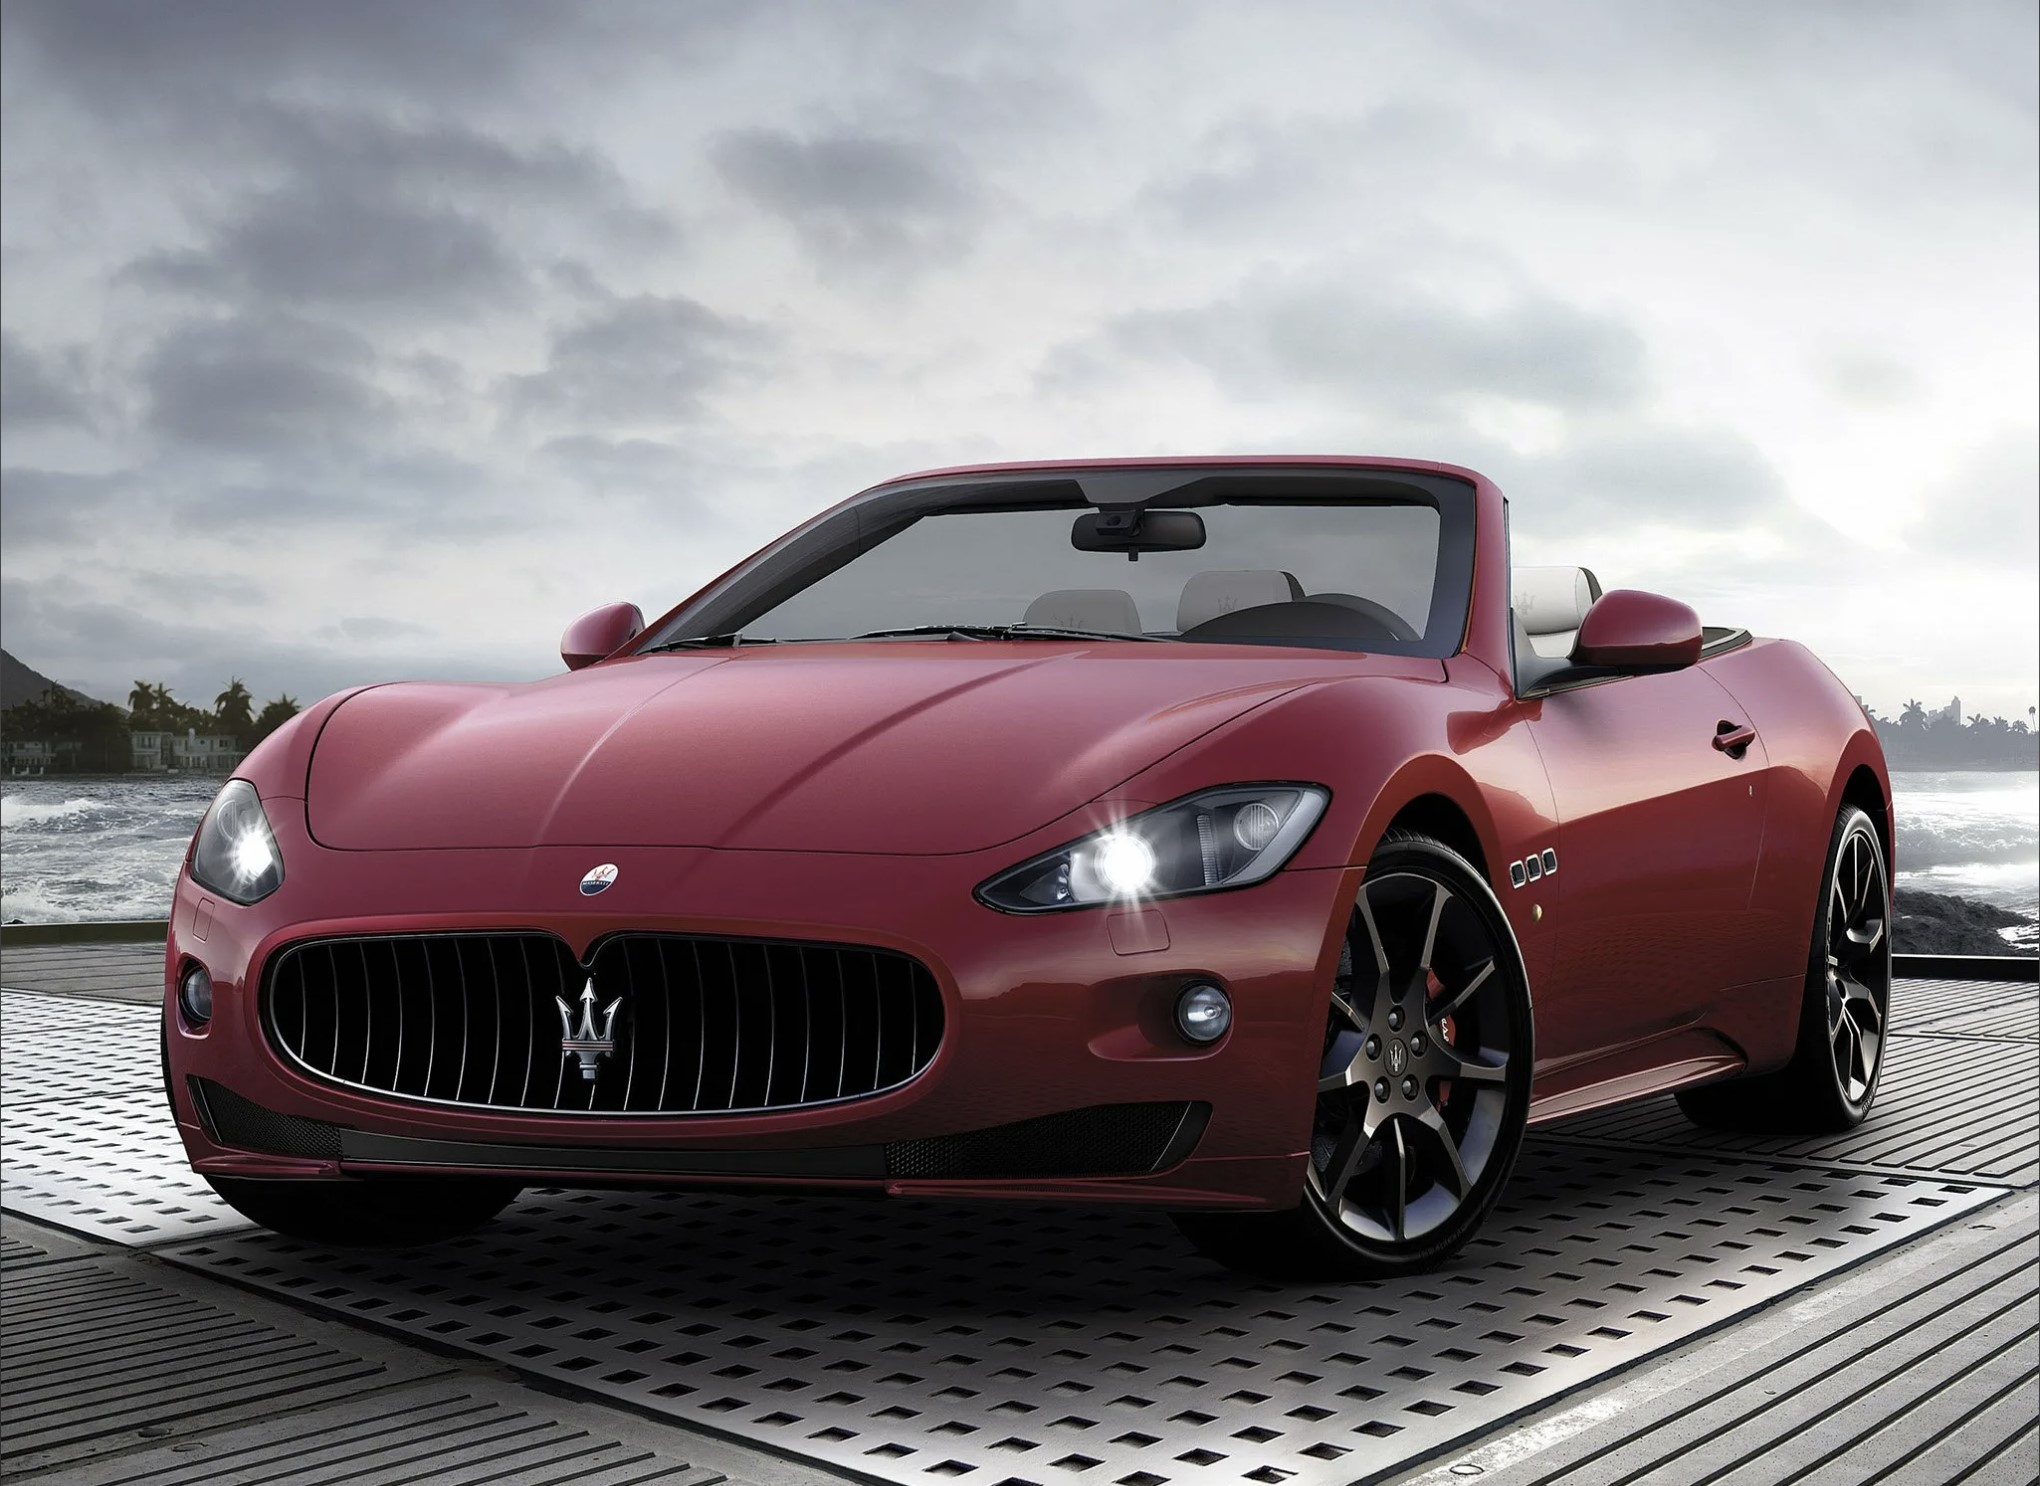

In [ ]:
def main():
    # Путь к сохраненному чекпоинту модели
    checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/model_196_cars-epoch=13-val_acc=0.9328.ckpt"
    model = EffNet.load_from_checkpoint(checkpoint_path, num_classes=196)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    intersecting_keys = set(model.state_dict().keys()) & set(checkpoint['state_dict'].keys())
    state_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in intersecting_keys}
    model.load_state_dict(state_dict)
    image_path = "/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/тест модели/20.jpg"
    predicted_class_index = predict_class(image_path, model, device)
    train_data_dir = "/content/drive/MyDrive/Colab Notebooks/МорозовДС_проект/car_data/train196"
    classes = ImageFolder(train_data_dir).classes
    predicted_class_name = classes[predicted_class_index]
    print("Predicted class:", predicted_class_name)

    # Открываем изображение и выводим его
    from IPython.display import Image
    width = 400
    height = 350
    display(Image(filename=image_path, width=width, height=height))

if __name__ == '__main__':
    main()